In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import ndimage
import xarray as xr

In [2]:
x = np.linspace(0, 10, 101)
y = np.linspace(0, 10, 101)
X, Y = np.meshgrid(x, y)

In [3]:
Z = np.exp(-(X - 3)**2 - (Y - 4)**2)
m = (Z > 0.2 ) | ((X > 6) & (X < 8) & (Y > 5) & (Y < 7))
m[20:40, 80] = True
m[60, 10:20] = True
m[42, 84] = True

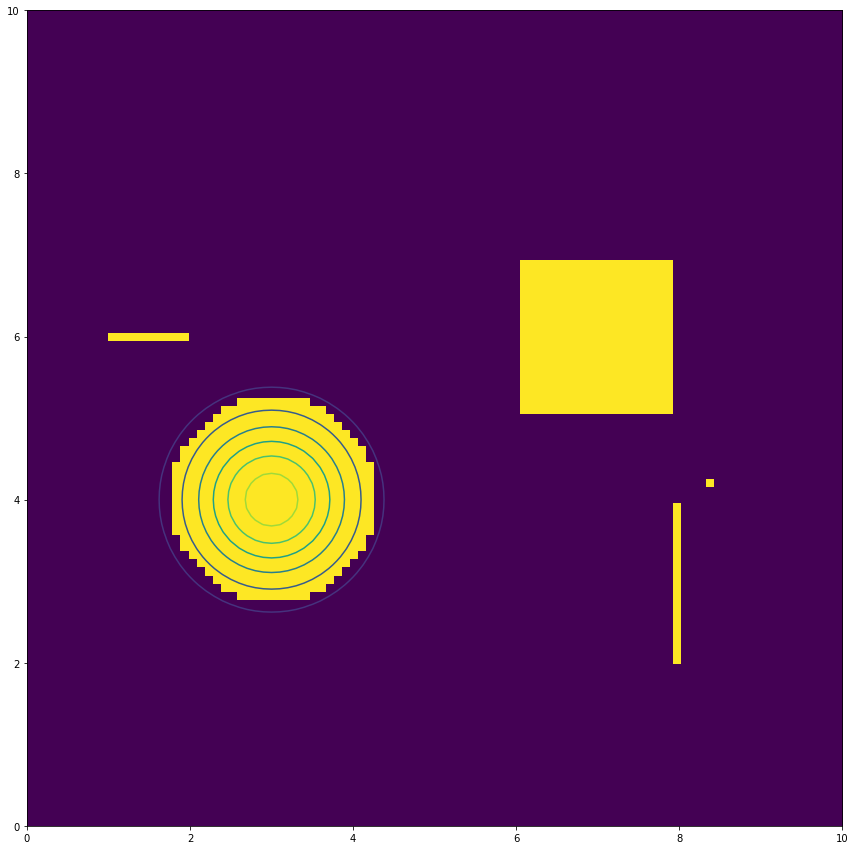

In [4]:
plt.figure(figsize=(15, 15))
plt.imshow(m, extent=(0, 10, 0, 10), origin='lower')
plt.contour(X, Y, Z)
# plt.contour(X, Y, m, levels=[0.5], colors=['k'])

In [5]:
l, nl = ndimage.label(m)

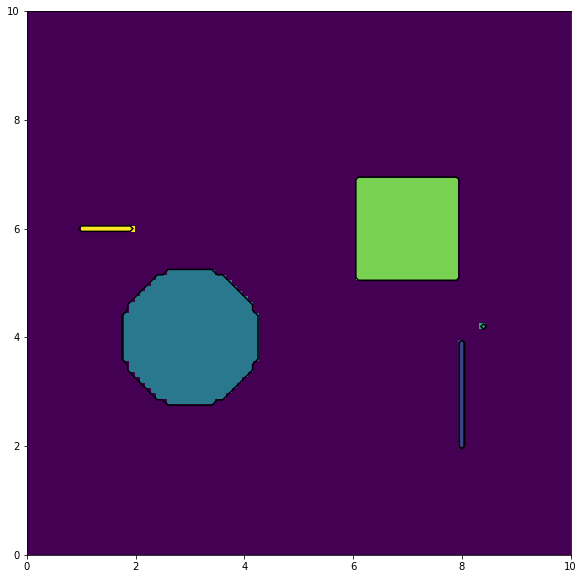

In [6]:
plt.figure(figsize=(10, 10))
plt.imshow(l, extent=(0, 10, 0, 10), origin='lower')
plt.contour(X, Y, m, levels=[0.5], colors=['k'])

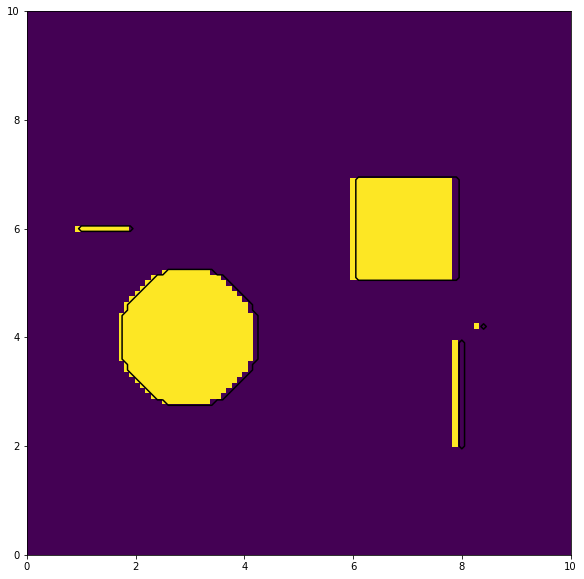

In [19]:
plt.figure(figsize=(10, 10))
plt.imshow(np.roll(m, -1, axis=1), extent=(0, 10, 0, 10), origin='lower')
plt.contour(X, Y, m, levels=[0.5], colors=['k'])

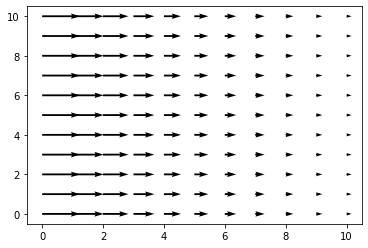

In [12]:
fx = np.exp(-X / 5)
fy = Y * 0
s = (slice(None, None, 10), slice(None, None, 10))
plt.quiver(X[s], Y[s], fx[s], fy[s])

In [14]:
fx = np.ones_like(X)
fy = np.zeros_like(X)
# c-grid flux.
cfx = (np.roll(fx, -1, axis=1) + fx) / 2
cfy = (np.roll(fy, -1, axis=0) + fy) / 2

In [15]:
dx = x[1] - x[0]
dy = y[1] - y[0]
cX = X + dx / 2
cY = Y + dy / 2

# 1st method. Calc divergence of flux and integrate

In [24]:
def calc_div_flux(flux_x, flux_y, dx, dy):
    dflux_dx = (flux_x - np.roll(flux_x, 1, axis=1)) / dx
    dflux_dy = (flux_y - np.roll(flux_y, 1, axis=0)) / dy

    return dflux_dx + dflux_dy

In [25]:
div_flux = calc_div_flux(cfx, cfy, dx, dy)

In [26]:
for i in range(1, 6):
    print(div_flux[l == i].sum() * dx * dy)

0.0
0.0
0.0
0.0
0.0


In [27]:
div_flux

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# 2nd method. Calc boundary of MCS then flux over boundary manually

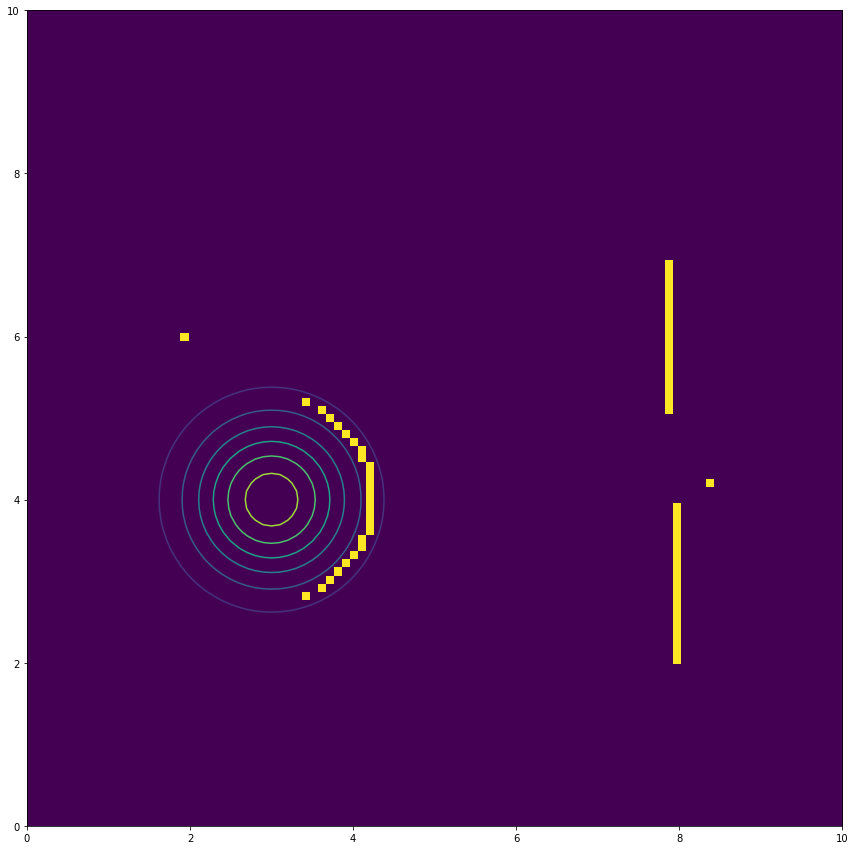

In [8]:
b = m & ~np.roll(m, -1, axis=1)
plt.figure(figsize=(15, 15))
plt.imshow(b, extent=(0, 10, 0, 10), origin='lower')
plt.contour(X, Y, Z)

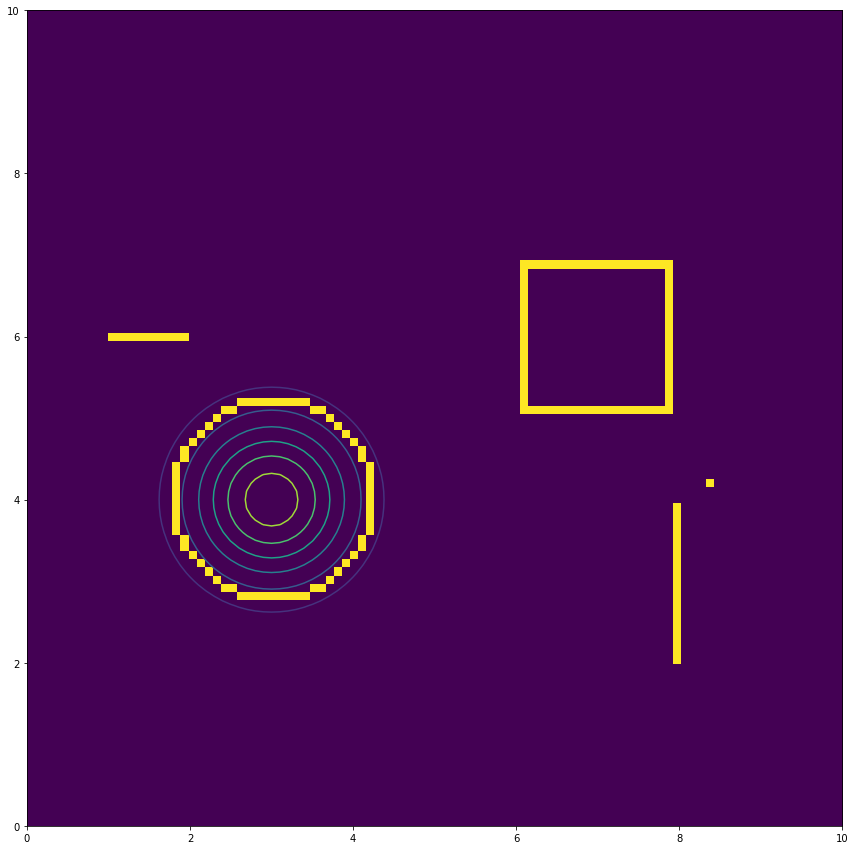

In [9]:
b = m & (~np.roll(m, -1, axis=0) | ~np.roll(m, -1, axis=1) | ~np.roll(m, 1, axis=0) | ~np.roll(m, 1, axis=1))
plt.figure(figsize=(15, 15))
plt.imshow(b, extent=(0, 10, 0, 10), origin='lower')
plt.contour(X, Y, Z)

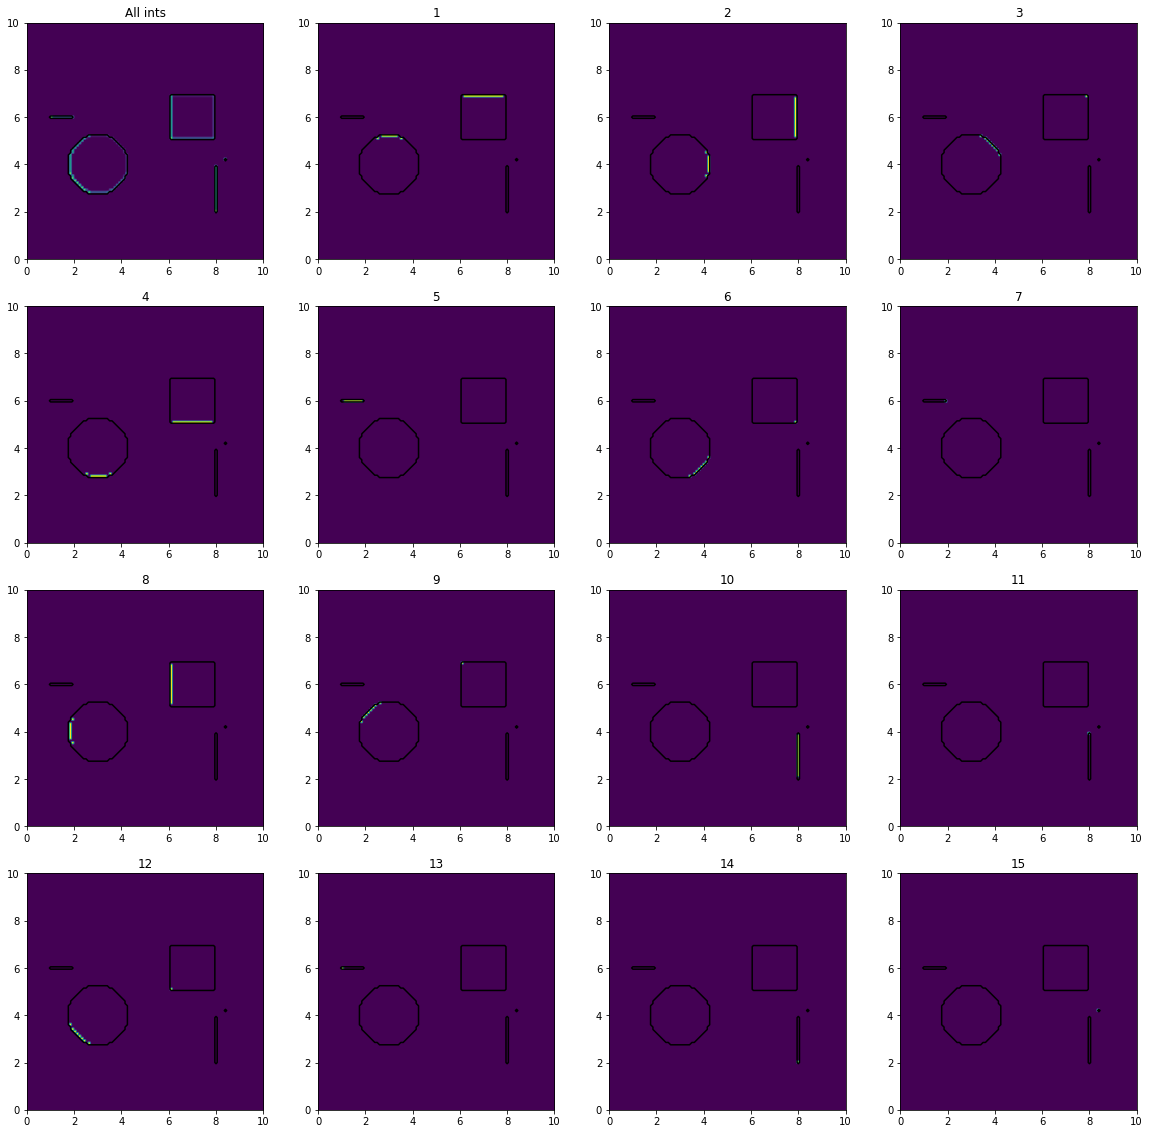

In [10]:
b2 = (
    1 * (m & ~np.roll(m, -1, axis=0)) + 
    2 * (m & ~np.roll(m, -1, axis=1)) + 
    4 * (m & ~np.roll(m, 1, axis=0)) + 
    8 * (m & ~np.roll(m, 1, axis=1))
).astype('int8')

fig, axes = plt.subplots(4, 4)
fig.set_size_inches((20, 20))

ax = axes[0, 0]
ax.set_title('All ints')
ax.imshow(b2, extent=(0, 10, 0, 10), origin='lower')
ax.contour(X, Y, m, levels=[0.5], colors=['k'])

for i in range(1, 16):
    ax = axes.flatten()[i]
    ax.set_title(i)
    ax.imshow(b2 == i, extent=(0, 10, 0, 10), origin='lower')
    ax.contour(X, Y, m, levels=[0.5], colors=['k'])

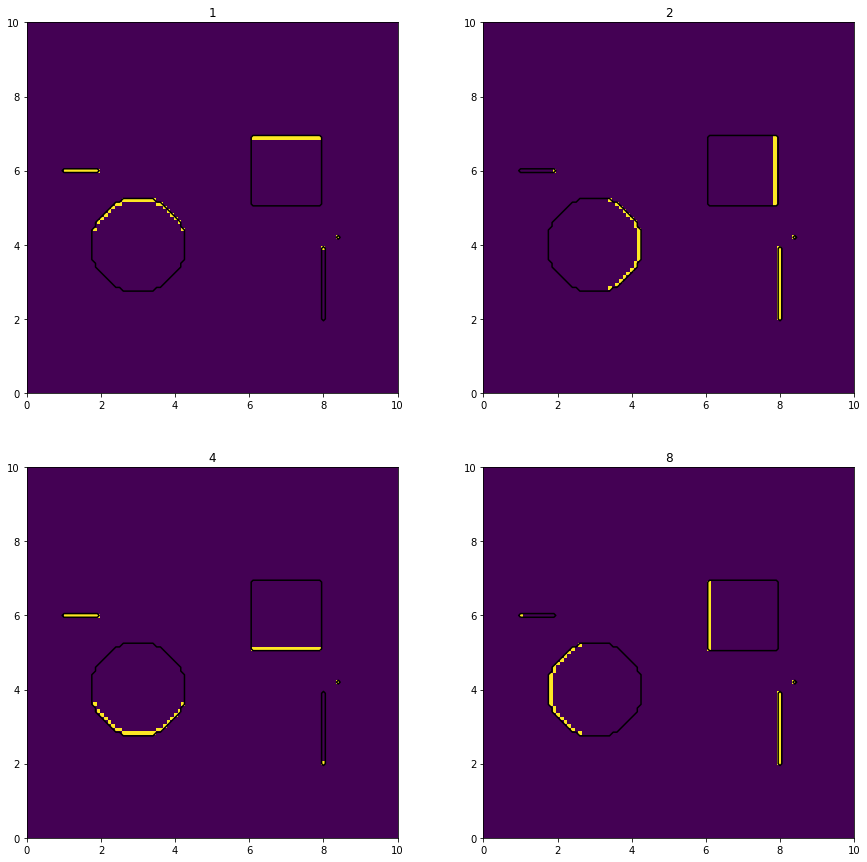

In [18]:
fig, axes = plt.subplots(2, 2)
fig.set_size_inches((15, 15))
for ax, i in zip(axes.flatten(), range(4)):
    ax.set_title(f'{2**i}')
    ax.imshow(b2 & 2**i, extent=(0, 10, 0, 10), origin='lower')
    ax.contour(X, Y, m, levels=[0.5], colors=['k'])

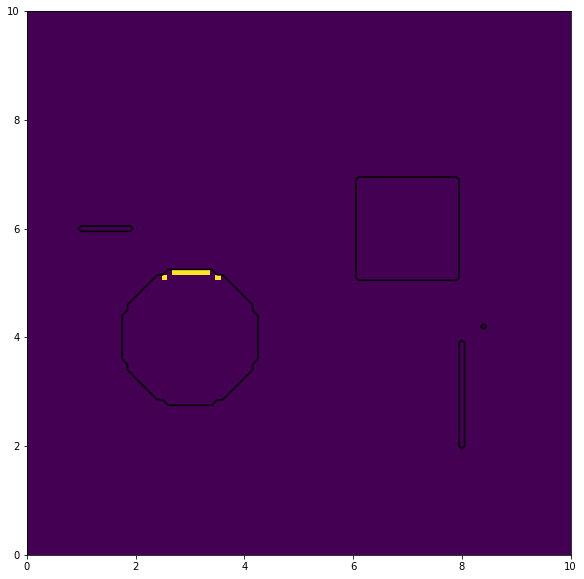

In [13]:
plt.figure(figsize=(10, 10))
plt.imshow((l == 2) & (b2 == 1), extent=(0, 10, 0, 10), origin='lower')
plt.contour(X, Y, m, levels=[0.5], colors=['k'])

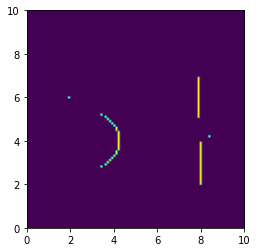

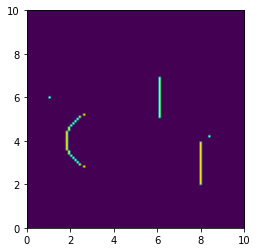

In [39]:
plt.imshow((b2 & 2), extent=(0, 10, 0, 10), origin='lower')
plt.figure()
plt.imshow((b2 & 8), extent=(0, 10, 0, 10), origin='lower')
plt.figure()
plt.imshow((b2 & 8), extent=(0, 10, 0, 10), origin='lower')


0.0
0.0
0.0
0.0
0.0


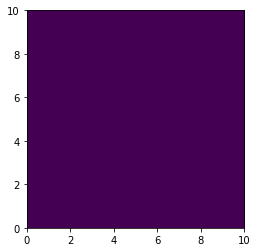

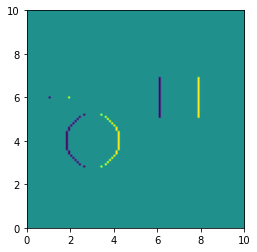

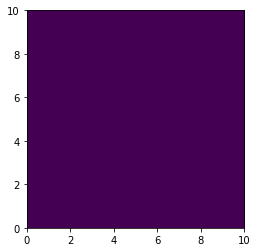

In [40]:
foutx = ((b2 & 2).astype(bool) * cfx - (b2 & 8).astype(bool) * np.roll(cfx, 1, axis=1)) * dx
fouty = ((b2 & 1).astype(bool) * cfy - (b2 & 4).astype(bool) * np.roll(cfy, 1, axis=0)) * dy
fout = foutx + fouty

for i in range(1, 6):
    print(fout[l == i].sum())

#fout[l == 2]

In [62]:
class FluxCalculator:
    @staticmethod
    def cell_centre_to_boundary(field, axis):
        return (np.roll(field, -1, axis=axis) + field) / 2

    def __init__(self, feature_mask, flux_x, flux_y, dx, dy):
        self.feature_mask = feature_mask
        self.feature_label, self.nfeature = ndimage.label(feature_mask)
        self.flux_x = flux_x
        self.flux_y = flux_y
        self.dx = dx
        self.dy = dy

    def calc_div(self):
        dflux_dx = (self.flux_x - np.roll(self.flux_x, 1, axis=1)) / self.dx
        dflux_dy = (self.flux_y - np.roll(self.flux_y, 1, axis=0)) / self.dy

        return dflux_dx + dflux_dy        

    def calc_boundary(self):
        return (
            1 * (self.feature_mask & ~np.roll(self.feature_mask, -1, axis=0)) + 
            2 * (self.feature_mask & ~np.roll(self.feature_mask, -1, axis=1)) + 
            4 * (self.feature_mask & ~np.roll(self.feature_mask, 1, axis=0)) + 
            8 * (self.feature_mask & ~np.roll(self.feature_mask, 1, axis=1))
        ).astype('int8')
        
    def integrate_div(self):
        div_flux = self.calc_div()
        return np.array([div_flux[self.feature_label == i].sum() * self.dx * self.dy for i in range(1, self.nfeature + 1)])
    
    def integrate_boundaries(self):
        bmask = self.calc_boundary()
        flux_outx = ((bmask & 2).astype(bool) * self.flux_x - (bmask & 8).astype(bool) * np.roll(self.flux_x, 1, axis=1)) * dx
        flux_outy = ((bmask & 1).astype(bool) * self.flux_y - (bmask & 4).astype(bool) * np.roll(self.flux_y, 1, axis=0)) * dy
        flux_out = flux_outx + flux_outy
        return np.array([flux_out[self.feature_label == i].sum() for i in range(1, self.nfeature + 1)])

In [63]:
fx = np.ones_like(X)
fy = np.zeros_like(X)

cfx = FluxCalculator.cell_centre_to_boundary(fx, 1)
cfy = FluxCalculator.cell_centre_to_boundary(fy, 1)

fc = FluxCalculator(m, cfx, cfy, dx, dy)
print(fc.integrate_div())
print(fc.integrate_boundaries())

[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]


[-0.03390516 -1.02014879 -0.00120862 -0.34749697 -0.01957818]
[-0.03390516 -1.02014879 -0.00120862 -0.34749697 -0.01957818]


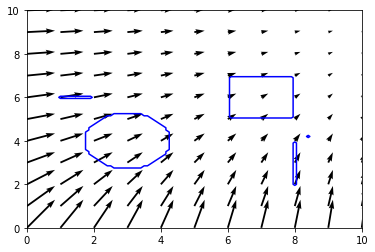

In [64]:
fx = np.exp(-X / 5)
fy = np.exp(-Y / 3)

s = (slice(None, None, 10), slice(None, None, 10))
plt.quiver(X[s], Y[s], fx[s], fy[s])
plt.contour(X, Y, m, levels=[0.5], colors=['b'])

cfx = FluxCalculator.cell_centre_to_boundary(fx, 1)
cfy = FluxCalculator.cell_centre_to_boundary(fy, 1)

fc = FluxCalculator(m, cfx, cfy, dx, dy)
print(fc.integrate_div())
print(fc.integrate_boundaries())

In [65]:
%%timeit
fc.integrate_div()

181 µs ± 4.75 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [66]:
%%timeit
fc.integrate_boundaries()

478 µs ± 11.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
